# **Homework 1 - ML for Time Series**

### Authors:
- Naïl Khelifa
- Tom Rossa

**Imports**

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)
from statsmodels.tsa.stattools import acf # for the sample autocorrelation function 
from scipy.signal import periodogram 
from sklearn.linear_model import Lasso
## Modules Question 10 
from dtw import dtw
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.utils import to_time_series_dataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc


**Utility functions**

In [8]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

Define the `plot_avg_with_std` routine to better observe the plot

In [65]:
def plot_avg_with_std_autocorr(x, y, N_samples, title=None, xlabel=None, ylabel=None):
  fig, ax = fig_ax(figsize=(15, 9))

  avg = y.mean(axis=0)
  std = y.std(axis=0)
  ax.plot(x, avg, 'k-', label=r'$\hat{\gamma}$ average (100 simulations'+ f' and {N_samples} samples)')
  ax.fill_between(x, avg - std, avg + std, alpha=0.5, label=r'$\hat{\gamma}$ standard deviation (100 simulations'+ f' and {N_samples} samples)')

  # Add markers on the edges
  ax.plot(x[0], avg[0], 'ro')  # Mark the start
  ax.plot(x[-1], avg[-1], 'ro')  # Mark the end
  
  # Add some space around the plot limits to make edges more visible
  ax.set_xlim(x[0] - 0.1 * (x[-1] - x[0]), x[-1] + 0.1 * (x[-1] - x[0]))
  plt.title(title)
  plt.xlabel(xlabel, fontsize=20)
  plt.ylabel(ylabel, fontsize=20)
  plt.legend(fontsize=20)
  plt.show()

def plot_avg_with_std_periodogram_barlett(x, y, N_samples, title=None, xlabel=None, ylabel=None):
  fig, ax = fig_ax(figsize=(15, 9))

  avg = y.mean(axis=0)
  std = y.std(axis=0)
  ax.plot(x, avg, 'k-', label=r'$|J(f_k)|^2_\text{Barlett}$'+f' average (100 simulations and {N_samples} samples)')
  ax.fill_between(x, avg - std, avg + std, alpha=0.5, label=r'$|J(f_k)|^2_\text{Barlett}$'+f' standard deviation(100 simulations and {N_samples} samples)')
    
  # Add markers on the edges
  ax.plot(x[0], avg[0], 'ro')  # Mark the start
  ax.plot(x[-1], avg[-1], 'ro')  # Mark the end
  
  ax.axhline(y=1.0, color='red', linestyle='--', linewidth=1.0, label='y = 1.0')  # Ligne horizontale en rouge

  # Add some space around the plot limits to make edges more visible
  ax.set_xlim(x[0] - 0.1 * (x[-1] - x[0]), x[-1] + 0.1 * (x[-1] - x[0]))
  plt.title(title)
  plt.xlabel(xlabel, fontsize=20)
  plt.ylabel(ylabel, fontsize=20)
  plt.legend(fontsize=20)
  plt.show()

def plot_avg_with_std_periodogram(x, y, N_samples, title=None, xlabel=None, ylabel=None):
  fig, ax = fig_ax(figsize=(15, 9))

  avg = y.mean(axis=0)
  std = y.std(axis=0)
  ax.plot(x, avg, 'k-', label=r'$|J(f_k)|^2$'+f' average (100 simulations and {N_samples} samples)')
  ax.fill_between(x, avg - std, avg + std, alpha=0.5, label=r'$|J(f_k)|^2$'+f' standard deviation(100 simulations and {N_samples} samples)')
    
  # Add markers on the edges
  ax.plot(x[0], avg[0], 'ro')  # Mark the start
  ax.plot(x[-1], avg[-1], 'ro')  # Mark the end

  ax.axhline(y=1.0, color='red', linestyle='--', linewidth=1.0, label='y = 1.0')  # Ligne horizontale en rouge
  
  # Add some space around the plot limits to make edges more visible
  ax.set_xlim(x[0] - 0.1 * (x[-1] - x[0]), x[-1] + 0.1 * (x[-1] - x[0]))
  plt.title(title)
  plt.xlabel(xlabel, fontsize=20)
  plt.ylabel(ylabel, fontsize=20)
  plt.legend(fontsize=20)
  plt.show()

# Spectral feature

## Question 1 (vérification)

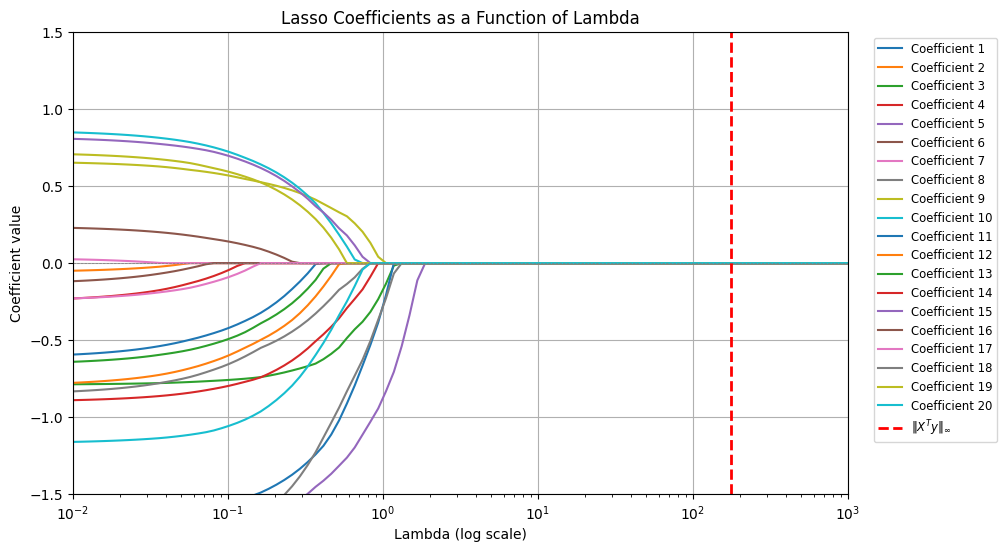

Value of lambda corresponding to ||X^Ty||_∞: 177.3666


In [9]:
# Generate synthetic data
np.random.seed(42)  # For reproducibility
n, p = 100, 20  # Number of samples (n) and features (p)
X = np.random.randn(n, p)
true_beta = np.random.randn(p)
y = X @ true_beta + np.random.randn(n) * 0.5  # y = X*beta + noise

# Calculate the infinity norm of X^T y
X_transpose_y = X.T @ y
lambda_inf = np.max(np.abs(X_transpose_y))

# Varying lambda
lambdas = np.logspace(-2, 3, 100)  # Range of lambda values
coefs = []

# Fit Lasso for different values of lambda
for l in lambdas:
    model = Lasso(alpha=l)
    model.fit(X, y)
    coefs.append(model.coef_)

# Convert to array for easier indexing
coefs = np.array(coefs)

# Plotting the coefficients as a function of lambda
plt.figure(figsize=(10, 6))
for i in range(p):
    plt.plot(lambdas, coefs[:, i], label=f'Coefficient {i + 1}')

plt.xscale('log')
plt.axhline(0, color='gray', lw=0.5, ls='--')
plt.axvline(lambda_inf, color='red', linestyle='--', label=r'$\|X^Ty\|_{\infty}$', linewidth=2)
plt.title('Lasso Coefficients as a Function of Lambda')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Coefficient value')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize='small')
plt.grid()
plt.ylim(-1.5, 1.5)
plt.xlim(0.01, 1000)  # Set x-axis limits to include the lambda_inf line
plt.show()

# Print the value of lambda_inf
print(f'Value of lambda corresponding to ||X^Ty||_∞: {lambda_inf:.4f}')

## Question 6

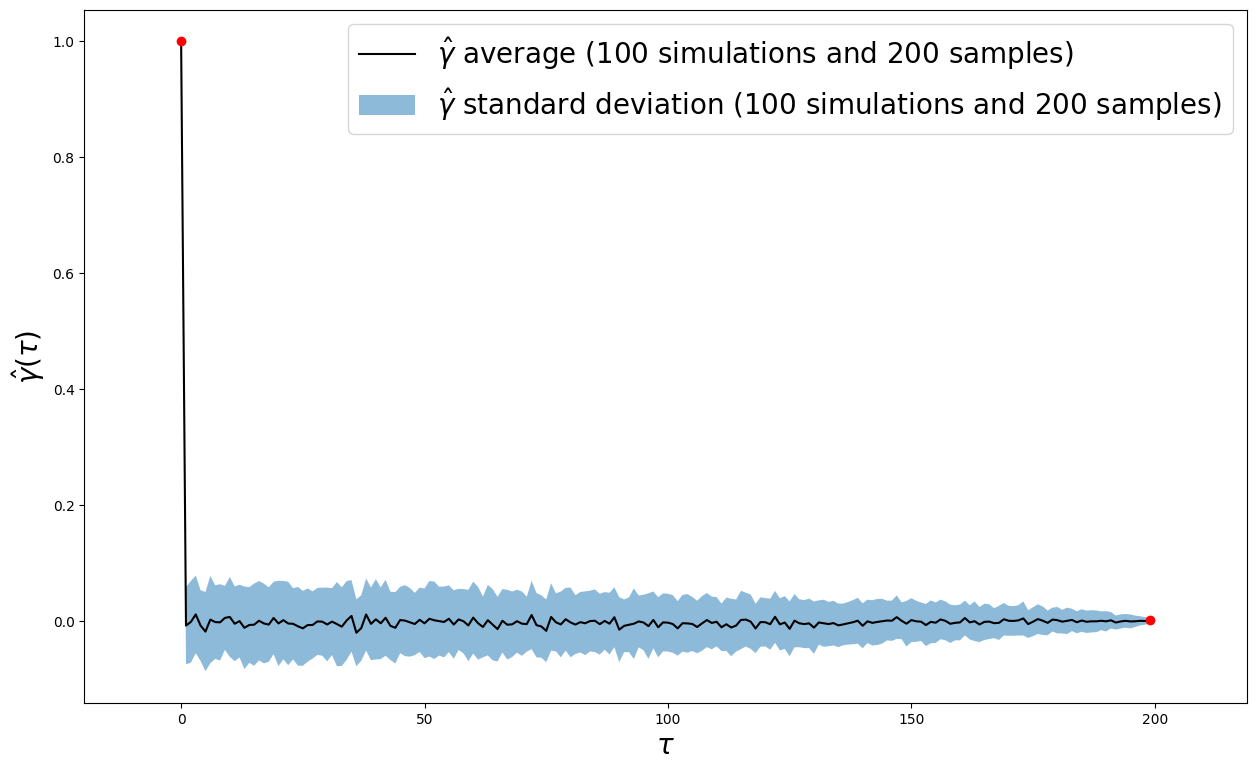

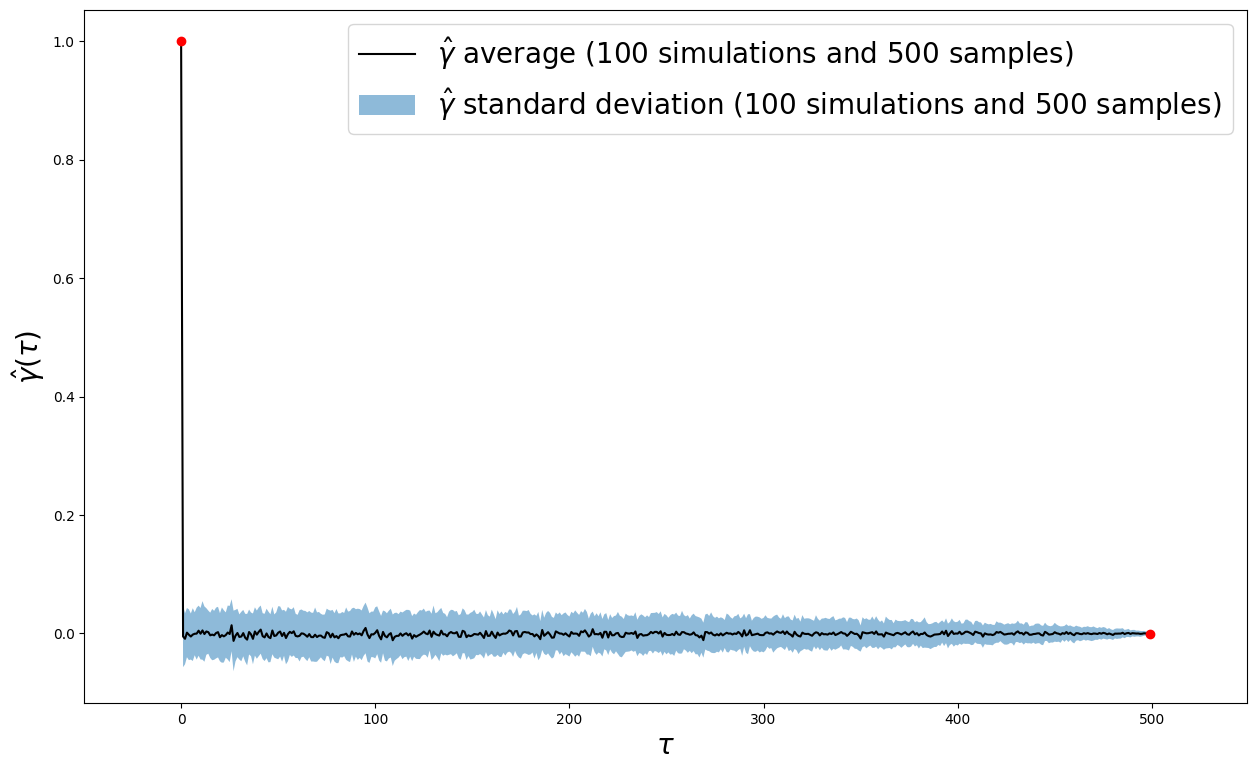

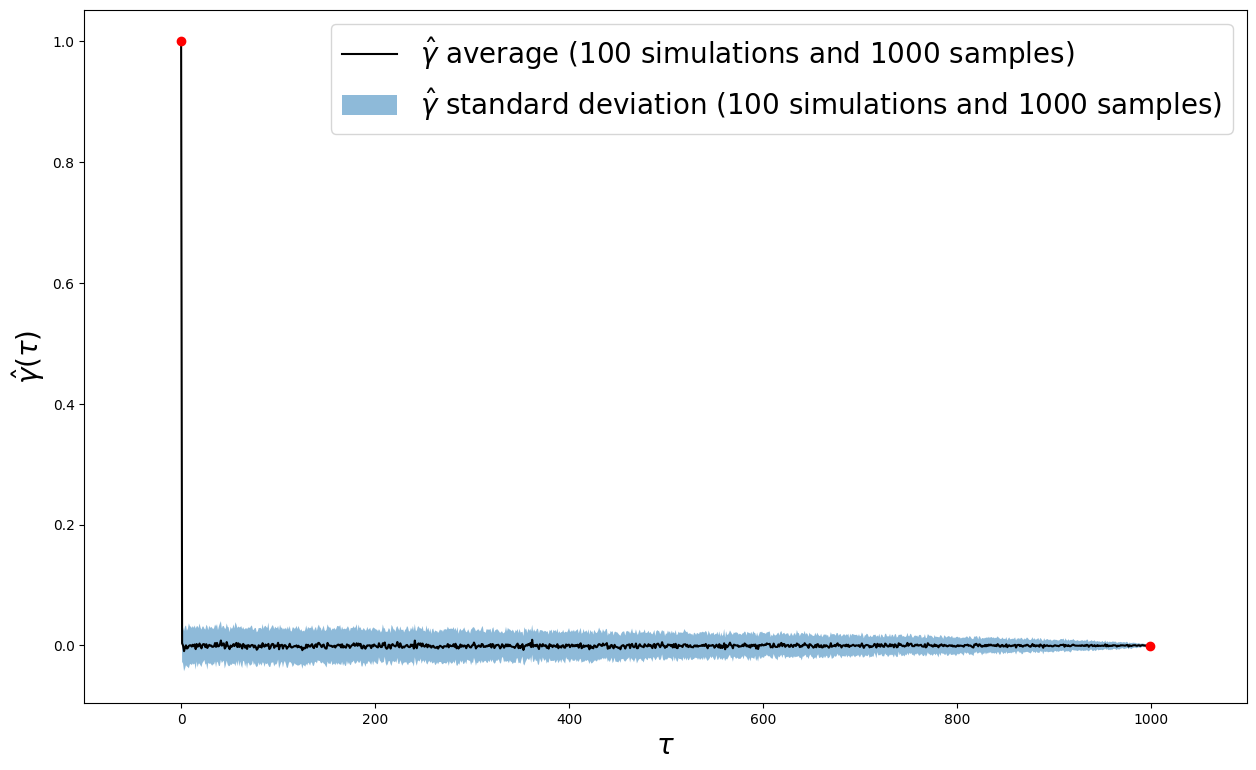

In [59]:
#  freqs = np.linspace(0, 0.5, N_samples) # since f_s = 1 Hz
N_trials = 100

for N_samples in [200, 500, 1000]:
    autocorr = []
    for _ in range(N_trials): # repeat this operation on the number of trials
        signal = np.random.randn(N_samples) # one realization of X_1, ..., X_N_samples (WGN)
        autocorr.append(acf(signal, nlags=N_samples, fft=True)) 

    autocorr = np.array(autocorr)

    y = np.arange(N_samples)
    
    plot_avg_with_std_autocorr(y, autocorr, N_samples, xlabel=r'$\tau$', ylabel=r'$\hat{\gamma}(\tau)$')

    plt.show()

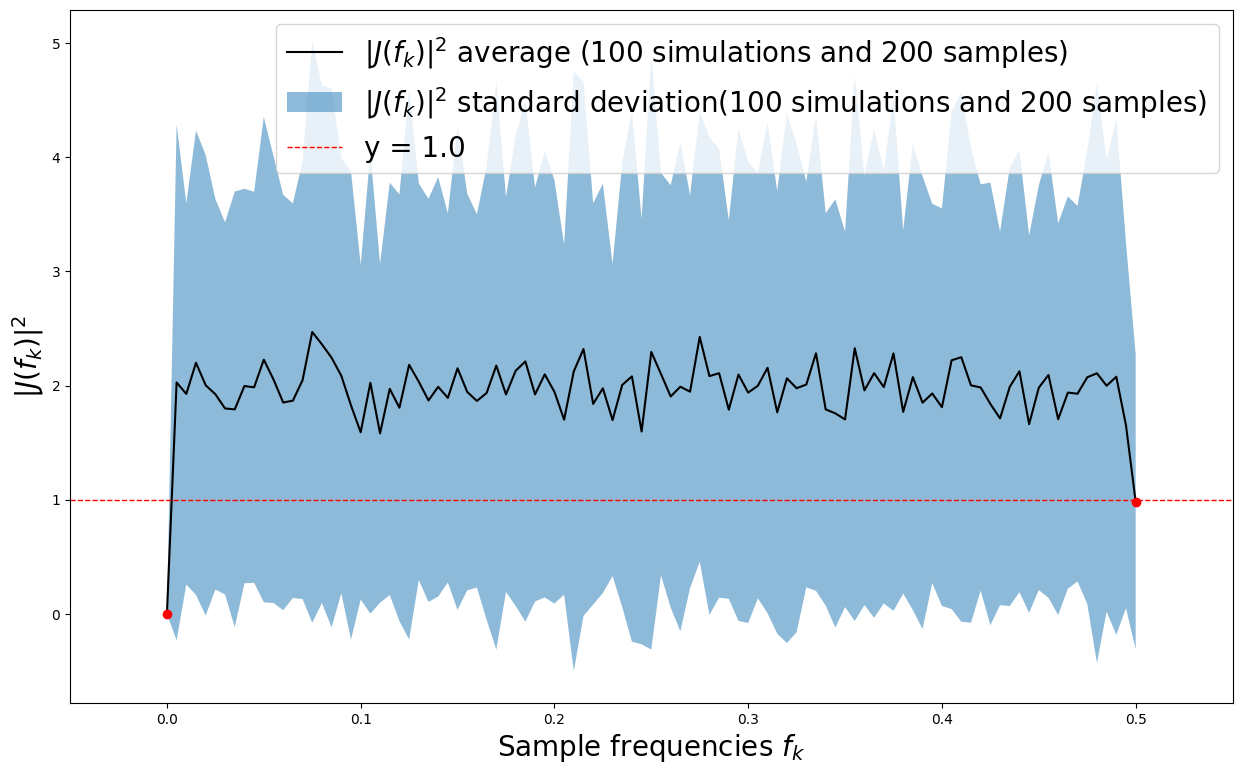

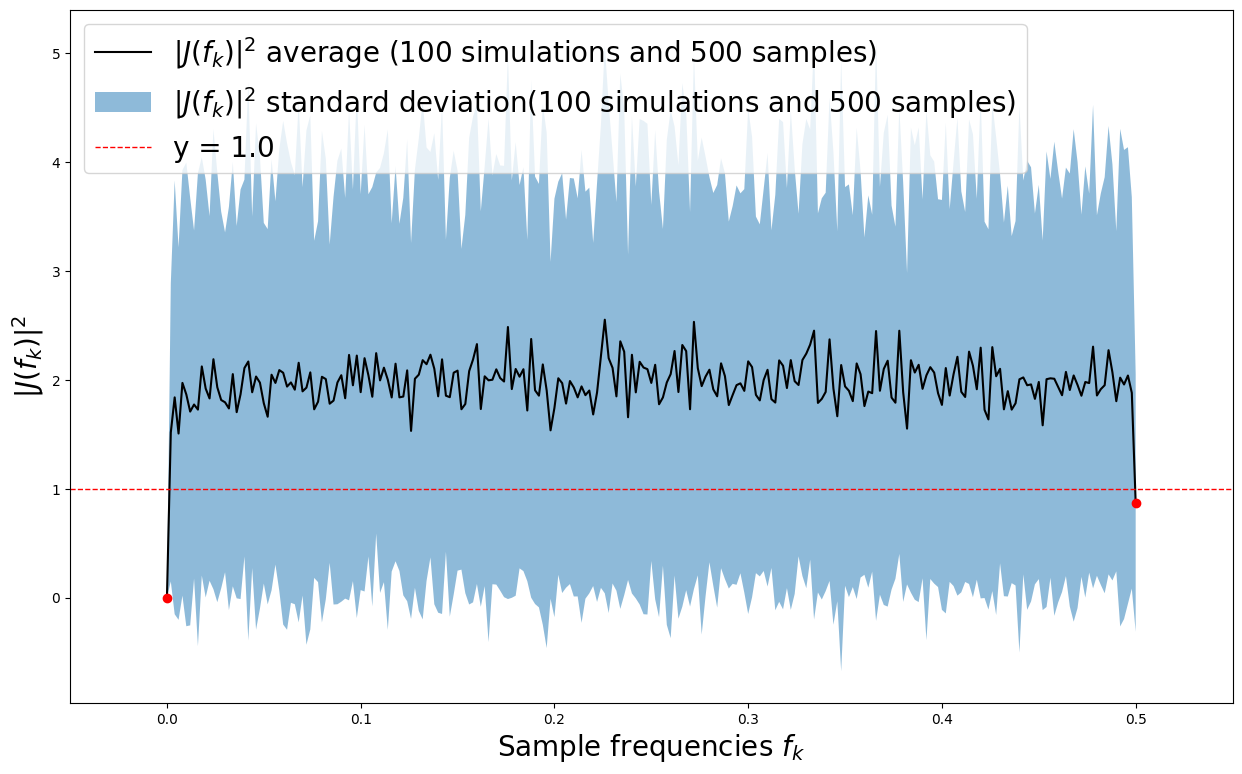

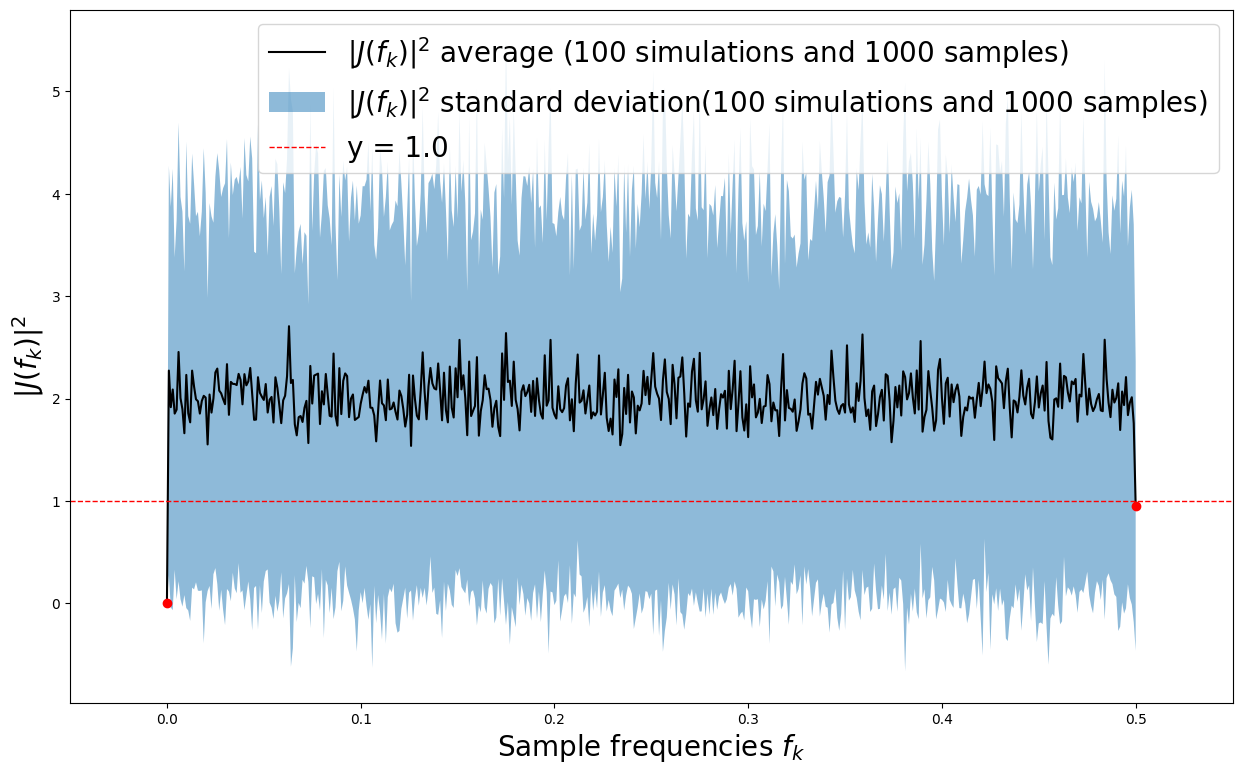

In [64]:
#  freqs = np.linspace(0, 0.5, N_samples) # since f_s = 1 Hz
N_trials = 100


for N_samples in [200, 500, 1000]:
    periodogram_arr = []
    sample_frequencies = []
    for _ in range(N_trials): # repeat this operation on the number of trials
        signal = np.random.randn(N_samples) # one realization of X_1, ..., X_N_samples (WGN)
        f, Pxx = periodogram(signal, fs=1.0)
        periodogram_arr.append(Pxx)
        sample_frequencies.append(f)

    sample_frequencies = np.array(sample_frequencies)
    periodogram_arr = np.array(periodogram_arr)

    plot_avg_with_std_periodogram(sample_frequencies[0], periodogram_arr, N_samples, xlabel=r'Sample frequencies $f_k$', ylabel=r'$|J(f_k)|^2$')

## Question 9

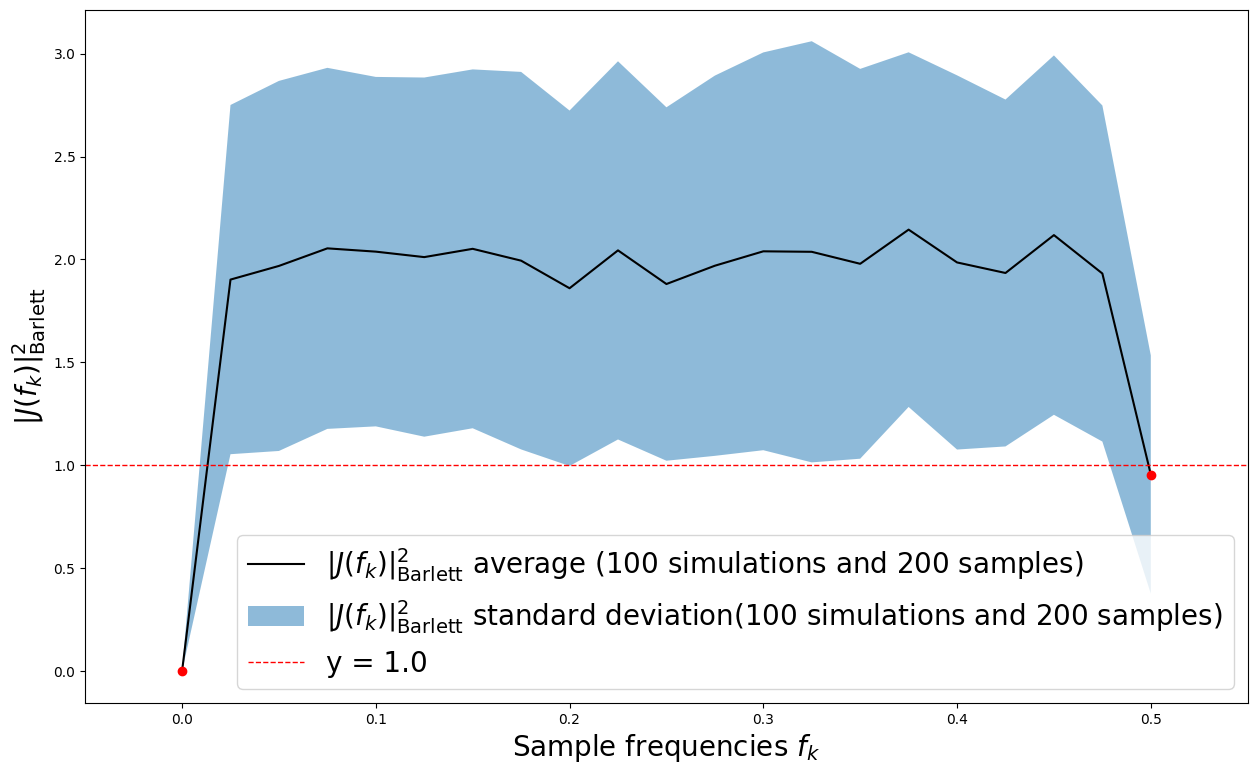

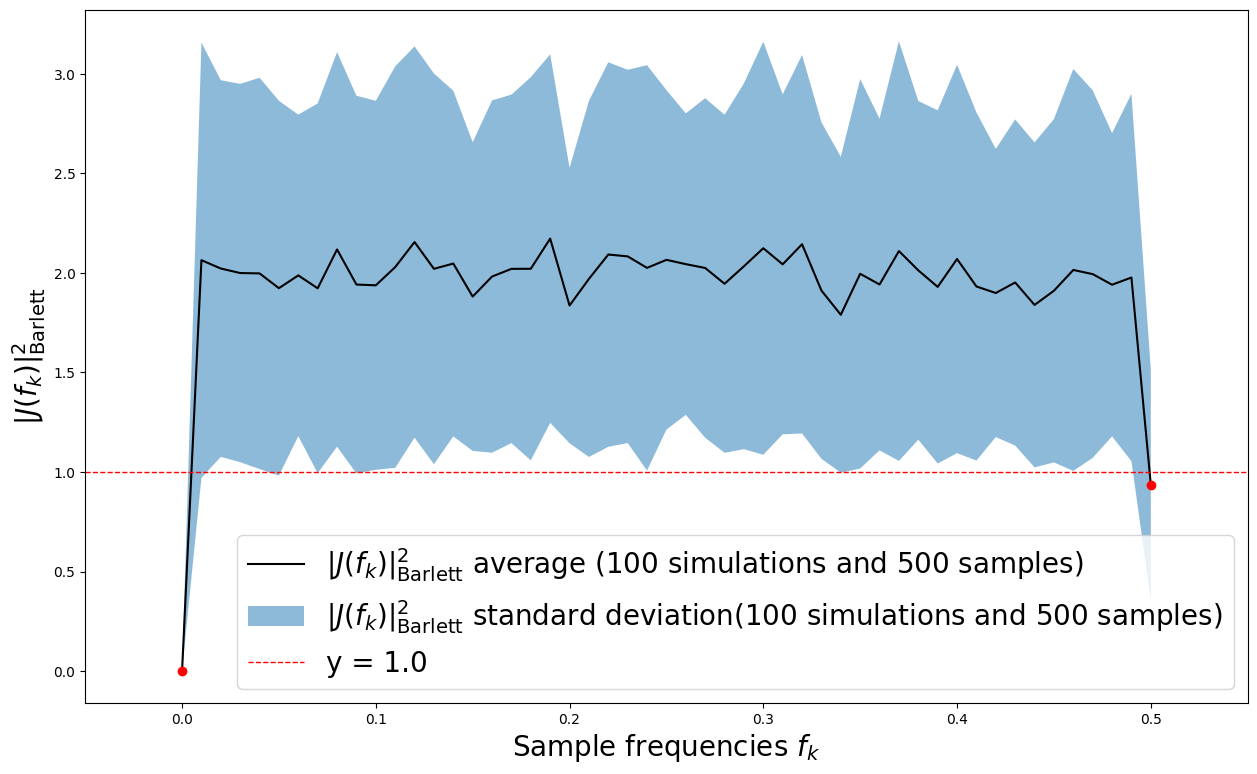

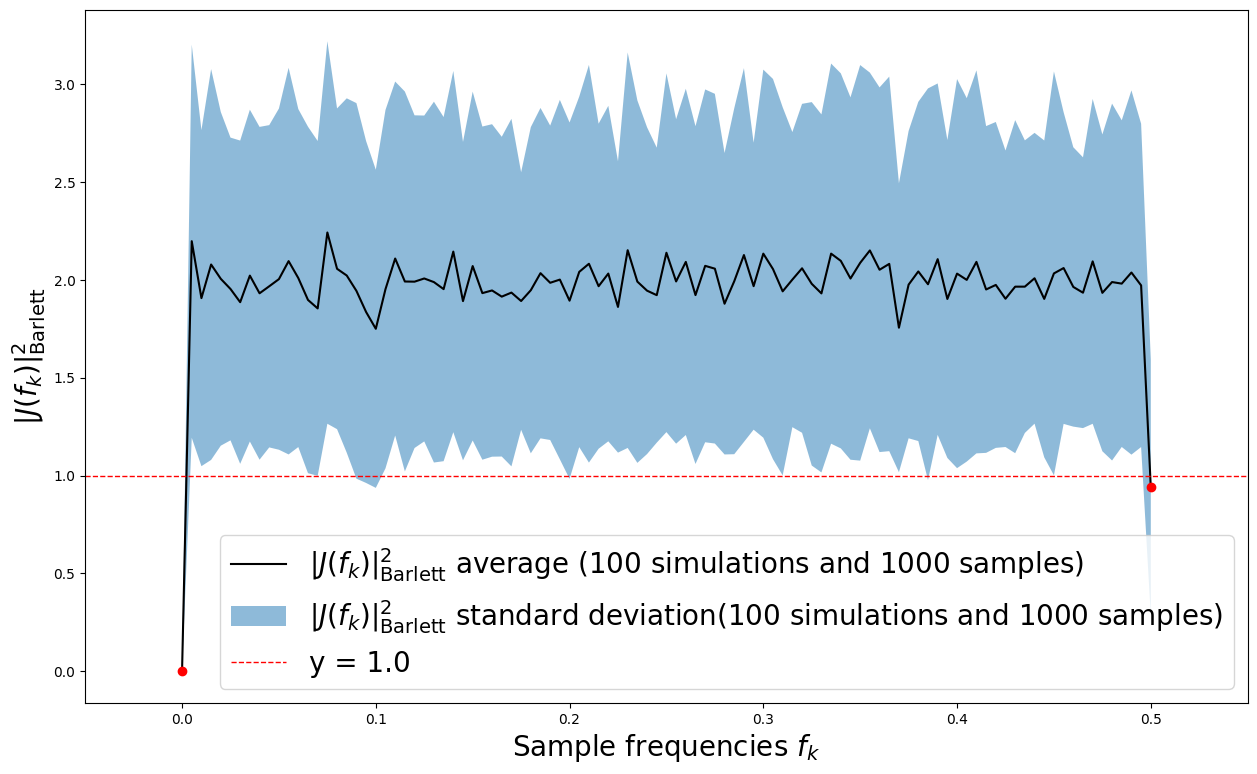

In [67]:
K = 5

for N_samples in [200, 500, 1000]:
    signals = np.random.randn(100, N_samples)
    section_length = N_samples // K
    sections = [
      signals[:,i*section_length:(i+1)*section_length]
      for i in range(K)
    ]
    sections = np.stack(sections, axis=2)
    freqs, periodograms = periodogram(sections, fs=1, axis=1) 
    bartlett_estimates = periodograms.mean(axis=-1)
    plot_avg_with_std_periodogram_barlett(freqs, bartlett_estimates, N_samples, xlabel=r'Sample frequencies $f_k$', ylabel=r'$|J(f_k)|^2_\text{Barlett}$')

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [14]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

100%|██████████| 202M/202M [22:40<00:00, 148kiB/s]    


## Question 10

Dans un premier, on construit une méthode de classification à partir des K-nearest-neighbors qui utilise la métrique DTW pour établir la distance entre deux séries temporelles. Pour chacune des séries du dataset de test, on attribue le label majoritaire parmi les $k$ plus proches séries du dataset de train en terme de DTW. 

In [40]:
class KNN_DTW:
    def __init__(self, X_train, y_train, k=5):
        self.X_train = X_train
        self.y_train = y_train
        self.k = k

    def DTW_dist(self, seq1, seq2):
        dist = dtw(seq1, seq2)
        return dist.distance

    def DTW_dist_accelerated(self, seq1, seq2):
        dist = accelerated_dtw(seq1, seq2)
        return dist.distance
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test, k=5):
        predictions = []
        for test_seq in X_test:
            distances = [self.DTW_dist(test_seq, train_seq) for train_seq in self.X_train]
            k_nearest = np.argsort(distances)[:k]
            k_nearest_labels = [self.y_train[i] for i in k_nearest]
            predictions.append(max(set(k_nearest_labels), key=k_nearest_labels.count))
        return predictions
    
    def predict_acc(self, X_test, k=5):
        predictions = []
        for test_seq in X_test:
            distances = [self.DTW_dist_accelearated(test_seq, train_seq) for train_seq in self.X_train]
            k_nearest = np.argsort(distances)[:k]
            k_nearest_labels = [self.y_train[i] for i in k_nearest]
            predictions.append(max(set(k_nearest_labels), key=k_nearest_labels.count))
        return predictions
    
    def get_params(self, deep=True):
        return {'k': self.k}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

Voilà à quoi on a accès avec DTW si besoin : distance, cost_matrix, acc_cost_matrix, path = dtw(sequence_1, sequence_2)

In [55]:
X_train = to_time_series_dataset(X_train)
X_test = to_time_series_dataset(X_test)

#knn_dtw = KNN_DTW(X_train, y_train, k=5)
knn_dtw = KNeighborsTimeSeriesClassifier(metric='dtw', n_jobs=-1)

k_grid = {
    'n_neighbors' : range(1, 51)
}

grid_search = GridSearchCV(
            estimator=knn_dtw, 
            param_grid=k_grid, 
            scoring='f1', #make_scorer(f1_score),
            cv=5,
            n_jobs=-1, 
            verbose=3)

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsTimeSeriesClassifier(n_jobs=-1),
             n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='f1')

Affichons le nombre optimal de nearest neighbors en terme de F1-Score, ainsi que le score associé : 

In [57]:
print(f"Meilleur K: {grid_search.best_params_['n_neighbors']} avec un F-score de {grid_search.best_score_:.4f}")

Meilleur K: 5 avec un F-score de 0.7818


On plot l'évolution du F1-Score en fonction du nombre de voisins que l'on choisit : 

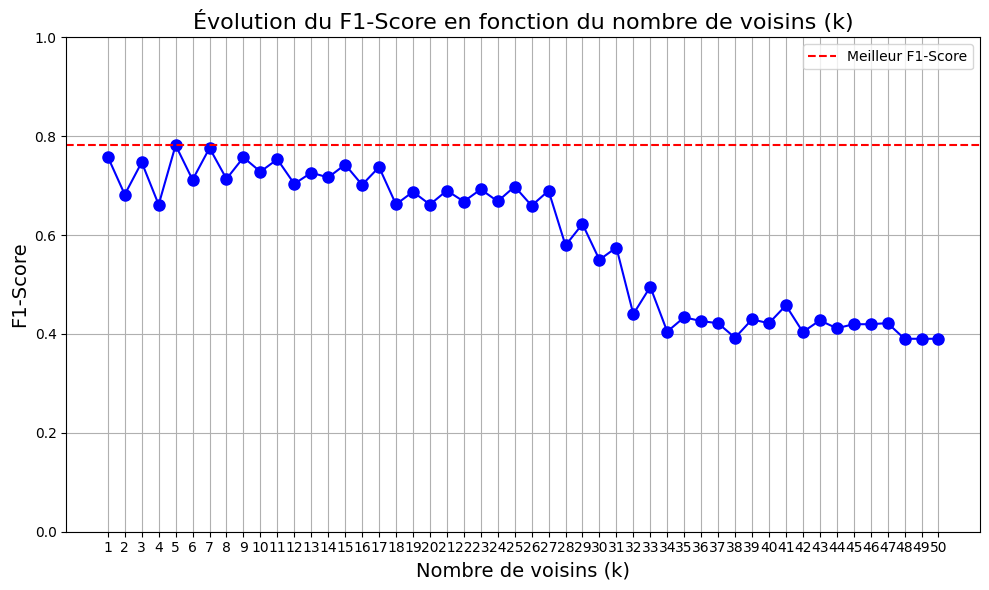

In [58]:
f1_scores = grid_search.cv_results_['mean_test_score']
k_values = range(1, 51)

plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores, marker='o', linestyle='-', color='b', markersize=8)

plt.title('Évolution du F1-Score en fonction du nombre de voisins (k)', fontsize=16)
plt.xlabel('Nombre de voisins (k)', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)

plt.grid(True)

plt.xticks(k_values) 
plt.ylim(0, 1)  # Limiter l'axe des y entre 0 et 1
plt.axhline(y=max(f1_scores), color='r', linestyle='--', label='Meilleur F1-Score')  ## Ligne pour indiquer le meilleur F1-score
plt.legend()
plt.tight_layout() 
plt.show()

On test avec la méthode accélérée pour voir? Plus on peut tester avec le package f1_score pour voir

In [ ]:
## (...)

Par cross-validation, nous avons identifié que le meilleur hyperparamètre semble être de prendre le nombre de voisins K = 5. Étudions désormais les performances de ce prédicteur sur l'échantillon de test : 

In [72]:
predictor = grid_search.best_estimator_
y_pred = predictor.predict(X_test)
y_scores = predictor.predict_proba(X_test)[:, 1]

F1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score de notre modèle sur le dataset de test: {F1:.4f}")

F1-score de notre modèle sur le dataset de test: 0.4474


In [13]:
cm = confusion_matrix(y_test, y_pred, display_labels=['Healthy', 'Non-healthy'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de Confusion')
plt.show()

NameError: name 'y_test' is not defined

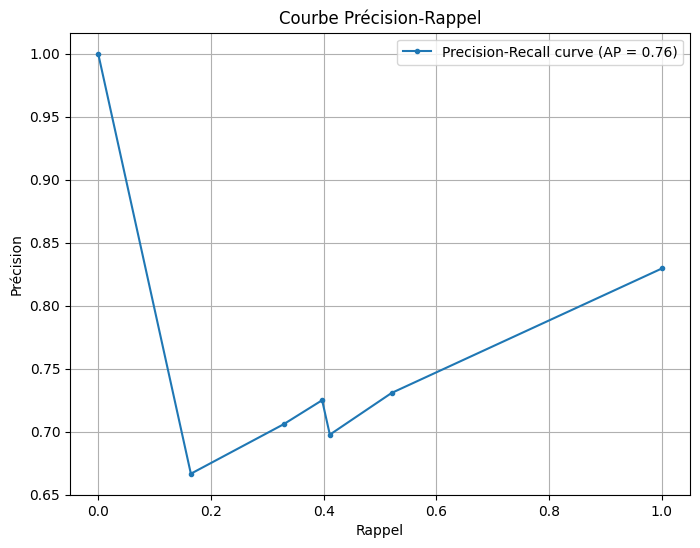

In [107]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve (AP = {:.2f})'.format(average_precision))
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe Précision-Rappel')
plt.legend()
plt.grid()
plt.show()

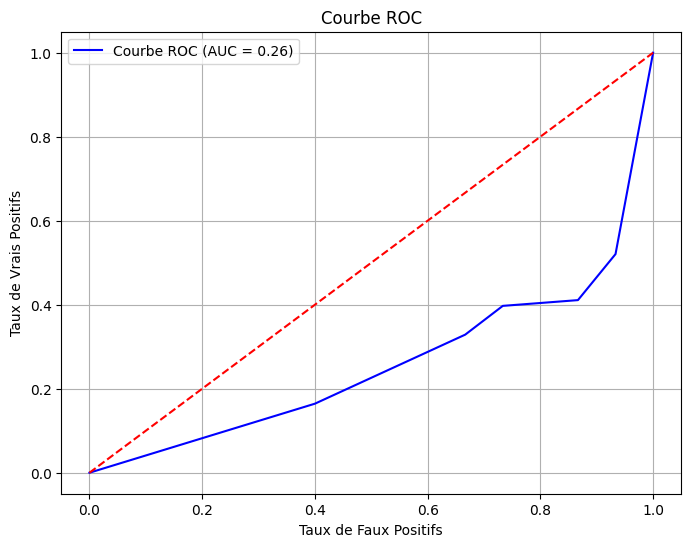

In [75]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Courbe ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Ligne de chance
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend()
plt.grid()
plt.show()

## Question 11

Au sein du Dataset de test, nous affichons la série d'un pas sain mal classifié (faux négatif) ainsi qu'un exemple de série d'un pas non-healthy mal classifié (faux positif). (Checker qu'est ce qui est positif ou non)

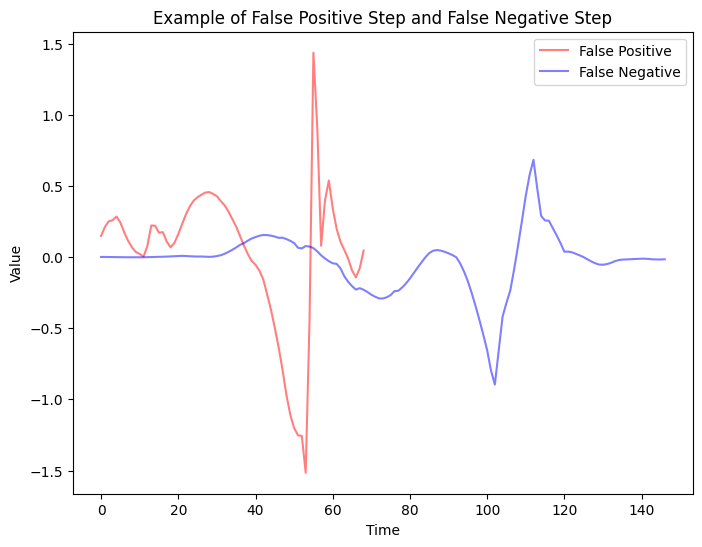

In [105]:
y_test = np.array(y_test)
false_positive_indices = np.where((y_test == 0) & (y_pred == 1))[0]
false_negative_indices = np.where((y_test == 1) & (y_pred == 0))[0]

false_positive_series = X_test[false_positive_indices][:1]
false_negative_series = X_test[false_negative_indices][:1]

fig, ax = plt.subplots(figsize=(8, 6))

for series in false_positive_series:
    ax.plot(series, label='False Positive', color='red', alpha=0.5)

# Tracer les faux négatifs
for series in false_negative_series:
    ax.plot(series, label='False Negative', color='blue', alpha=0.5)

# Ajouter des légendes et des titres
ax.set_title('Example of False Positive Step and False Negative Step')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend(['False Positive', 'False Negative'])
plt.show()